In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import requests
import math

from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib import colormaps

from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite

from astropy import coordinates as coordinates
from astropy.time import Time
from astropy.io import fits

In [2]:
# Get DF with TLE for appropriate dates for each satellite
 
# 38991: Star One C3
# 41886: GOES-16

def get_TLE_dataframe(satellite_id, start_jd, end_jd):

    url = 'https://cps.iau.org/tools/satchecker/api/tools/get-tle-data/'
    params = {'id': satellite_id,
            'id_type': 'catalog',
            'start_date_jd': start_jd,
            'end_date_jd': end_jd
            }
    r = requests.get(url, params=params)
    df = pd.DataFrame(r.json())

    df['epoch'] = pd.to_datetime(df['epoch'], utc=True)
    df.set_index('epoch', inplace=True)

    # Get rid of duplicate TLEs
    df = df[~df.index.duplicated(keep='first')]

    return df

goes_tle = get_TLE_dataframe(41866, 2460422, 2460426 )
starone_tle = get_TLE_dataframe(38991, 2460422, 2460426 )
#starone_tle

In [3]:
# Get hand scanned satellite data from processed fits files

satellite_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRs-6gh1dIAjqTUdN-UOpQmaohx1U3ecO8vrb2EHUbBkoPeV14XWbtPW60-vy7cQt1Wcf1022tSo61J/pub?output=csv'
satellite_df = pd.read_csv(satellite_data)
satellite_df = satellite_df.set_index(['obsid', 'satellite'])
satellite_df[:4]

RA_Start  DEC_Start  Error_Start  \
obsid                   satellite                                         
GC102_O_20240422_000023 GOES 16      154.582710   5.053327        3.359   
                        STAR ONE C3  154.828027   5.095980        3.314   
GC102_O_20240422_000024 GOES 16      154.624067   5.053418        4.355   
                        STAR ONE C3  154.867670   5.096189        4.390   

                                         RA_End   DEC_End  Error_End  
obsid                   satellite                                     
GC102_O_20240422_000023 GOES 16      154.603475  5.053447      3.596  
                        STAR ONE C3  154.849251  5.095970      2.692  
GC102_O_20240422_000024 GOES 16      154.641134  5.053312      4.407  
                        STAR ONE C3  154.889026  5.095711      4.650

In [4]:
#Functions to return the closest matching TLE and calculated position on the sky

def get_matching_tle(df, tai_time):
    
    # Convert to datetime format for pandas
    exp_time = pd.to_datetime([tai_time.utc_iso()], utc=True)
    epoch_index = df.index.get_indexer(exp_time, method='nearest')

    best_tle_time = df.index[epoch_index]
    tle_delay = (best_tle_time - exp_time)/pd.Timedelta(hours=1)

    sat_name = df.satellite_name.iloc[epoch_index]
    TLE1 = df.tle_line1.iloc[epoch_index]
    TLE2 = df.tle_line2.iloc[epoch_index]

    return sat_name, best_tle_time, tle_delay, TLE1, TLE2


def calculate_position(satellite_tle, Earth_location, timescale, tai_time, time_offset=0):  

    # Add a delta time to the header time if necessary.  
    tai_time = tai_time + timedelta(seconds=time_offset)
    
    sat_name, best_tle_time, tle_delay, tle_line1, tle_line2 = get_matching_tle(satellite_tle, tai_time)
    satellite = EarthSatellite(tle_line1.iloc[0], tle_line2.iloc[0], sat_name.iloc[0], timescale)
    sat_ra, sat_dec, sat_dist = (satellite - Earth_location).at(tai_time).radec()

    return (tai_time, sat_name.iloc[0], best_tle_time[0], tle_delay[0], tle_line1.iloc[0], tle_line2.iloc[0], 
            sat_ra._degrees, sat_dec.degrees)


In [5]:
# Read metadata from processed FITS files and build a dataframe

# Set the location of the observatory 
rubin_obs = coordinates.EarthLocation.of_site('Rubin Observatory')
Rubin= wgs84.latlon(rubin_obs.lat.deg, rubin_obs.lon.deg, rubin_obs.height.value)

ts = load.timescale()
records_list = []

for entry in sorted(os.scandir('/Users/walter/processed-fits'), key=lambda x: x.name):
    with fits.open(entry.path) as hdu_list: 

        hdu = hdu_list[0]
        obs_id = hdu.header['OBSID']

        tai_obs_date = ts.from_astropy(Time(hdu.header['DATE-BEG'], scale='tai'))

        position_tuple = calculate_position(goes_tle, Rubin, ts, tai_obs_date, time_offset=0)
        records_list.append([obs_id] + [*position_tuple])

        position_tuple = calculate_position(starone_tle, Rubin, ts, tai_obs_date, time_offset=0)
        records_list.append([obs_id] + [*position_tuple])

df = pd.DataFrame(records_list, columns=['obsid','TAI_time', 'satellite', 
                                         'best TLE', 'tle_delay', 'tle_line1', 'tle_line2',
                                         'RA', 'DEC'])
df = df.join(satellite_df, on=['obsid','satellite'])
df[:4]


,obsid,TAI_time,satellite,best TLE,tle_delay,tle_line1,tle_line2,RA,DEC,RA_Start,DEC_Start,Error_Start,RA_End,DEC_End,Error_End
0,GC102_O_20240422_000023,<Time tt=2460423.5540866437>,GOES 16,2024-04-22 14:23:36+00:00,-10.885556,1 41866U 16071A 24113.59973341 -.00000238 0...,2 41866 0.0153 282.4376 0000662 125.3279 304...,154.584239,5.065669,154.582710,5.053327,3.359,154.603475,5.053447,3.596
1,GC102_O_20240422_000023,<Time tt=2460423.5540866437>,STAR ONE C3,2024-04-23 12:43:58+00:00,11.453889,1 38991U 12062A 24114.53054333 -.00000236 0...,2 38991 0.0341 98.0485 0001715 317.1161 272...,154.828023,5.089200,154.828027,5.095980,3.314,154.849251,5.095970,2.692
2,GC102_O_20240422_000024,<Time tt=2460423.5541955903>,GOES 16,2024-04-22 14:23:36+00:00,-10.888056,1 41866U 16071A 24113.59973341 -.00000238 0...,2 41866 0.0153 282.4376 0000662 125.3279 304...,154.623573,5.065703,154.624067,5.053418,4.355,154.641134,5.053312,4.407
3,GC102_O_20240422_000024,<Time tt=2460423.5541955903>,STAR ONE C3,2024-04-23 12:43:58+00:00,11.451389,1 38991U 12062A 24114.53054333 -.00000236 0...,2 38991 0.0341 98.0485 0001715 317.1161 272...,154.867355,5.089246,154.867670,5.096189,4.390,154.889026,5.095711,4.650


In [6]:
df = df.assign(delta_ra = lambda x: (x.RA_Start - x.RA)*3600) \
       .assign(delta_dec = lambda x: (x.DEC_Start - x.DEC)*3600) \
       .assign(abs_tle_delay = lambda x: abs(x.tle_delay)) \
       .assign(abs_delta_ra = lambda x: abs(x.delta_ra)) \
       .assign(abs_delta_dec = lambda x: abs(x.delta_dec)) 
               
GOES = df.groupby('satellite').get_group('GOES 16')
STARONE = df.groupby('satellite').get_group('STAR ONE C3')

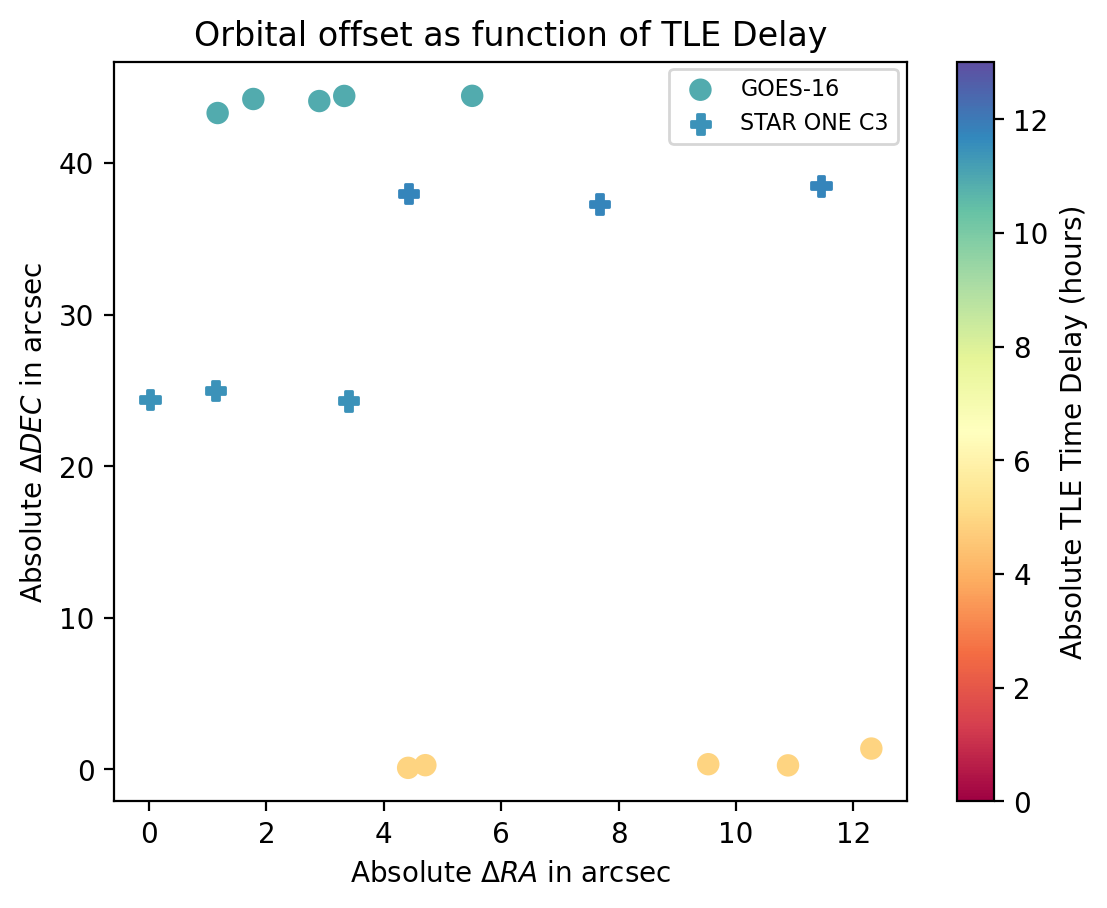

In [7]:
colormap = colormaps['Spectral']
norm = colors.Normalize(vmin=0, vmax=13)

ax1 = GOES.plot.scatter('abs_delta_ra', 'abs_delta_dec', marker='o', s=50, c='abs_tle_delay', norm=norm, cmap=colormap, label='GOES-16')
ax2 = STARONE.plot.scatter('abs_delta_ra', 'abs_delta_dec', marker='P', s=50, c='abs_tle_delay', norm=norm, cmap=colormap, label='STAR ONE C3', colorbar=False, ax=ax1)

plt.title('Orbital offset as function of TLE Delay')
plt.xlabel('Absolute $\Delta RA$ in arcsec')
plt.ylabel('Absolute $\Delta DEC$ in arcsec')

colorbar_axis = plt.gcf().get_axes()[1]
colorbar_axis.set_ylabel('Absolute TLE Time Delay (hours)')

plt.legend(loc=(.7,.89), fontsize=8);

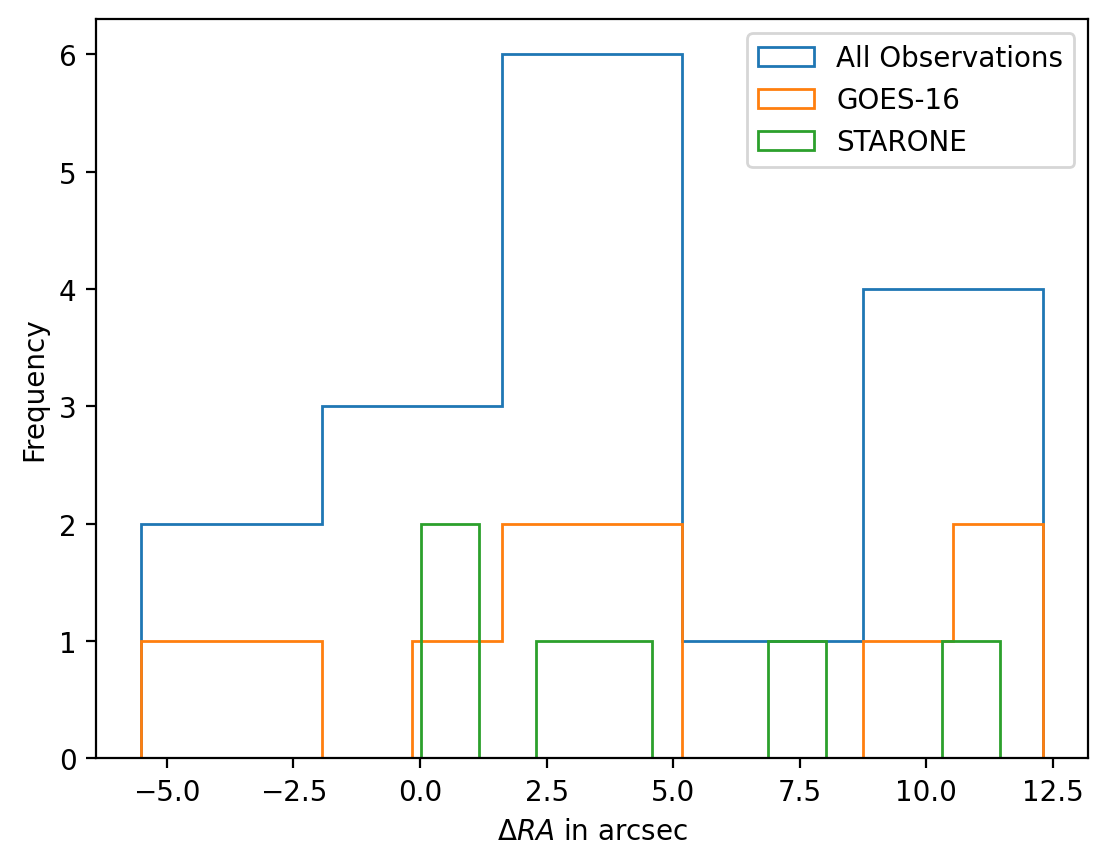

In [8]:
# Look at the distribution of delta_ras

df.delta_ra.plot.hist(bins=5, histtype='step', label='All Observations')
GOES.delta_ra.plot.hist(bins=10, histtype='step', label='GOES-16')
STARONE.delta_ra.plot.hist(bins=10, histtype='step', label='STARONE')

plt.xlabel('$\Delta RA$ in arcsec')
plt.legend(fontsize=10);

In [9]:
# Calculate the mean errors and the start error positions I measured

print(f'GOES: \t {GOES.delta_ra.mean():4.2f} (+-{GOES.delta_ra.std():4.2f}) +- {GOES.Error_Start.mean():4.2f}')
print(f'STARONE: {STARONE.delta_ra.mean():4.2f} (+-{STARONE.delta_ra.std():4.2f}) +- {STARONE.Error_Start.mean():4.2f}')
print(f'ALL: \t {df.delta_ra.mean():4.2f} (+-{df.delta_ra.std():4.2f}) +- {df.Error_Start.mean():4.2f}')

#ax1 = GOES.hist('Error_Start', bins=10, histtype='step', grid=False)
#ax2 = STARONE.hist('Error_Start', bins=10, histtype='step', grid=False, ax=ax1)

GOES: 	 3.89 (+-5.83) +- 4.13
STARONE: 4.68 (+-4.26) +- 4.01
ALL: 	 4.18 (+-5.16) +- 4.09


In [10]:
# Calculate the average error in RA but weight the entires by my measured errors 
# on the start positions.
#
# See https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy

values = df.dropna().delta_ra
weights = df.dropna().Error_Start
weighted_avg = np.average(values, weights=weights)
weighted_std = math.sqrt(np.average((values-weighted_avg)**2, weights=weights))

print('Rough guess on precision:')
print(f'Weighted averages: {weighted_avg:4.2f}" +- {weighted_std:4.2f}"')
print(f'In milliseconds: {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000:4.2f} ms')
print(f'In milliseconds scaled by sqrt(18): {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000/math.sqrt(18):4.2f} ms')

Rough guess on precision:
Weighted averages: 4.62" +- 4.92"
In milliseconds: 308.09 ms +- 327.97 ms
In milliseconds scaled by sqrt(18): 308.09 ms +- 77.30 ms


In [11]:
# Make a clean DF for some set of satellites without any NaNs to use with PDF
clean_df = df[:].dropna()

def calculate_position_df(data_frame, Earth_location, timescale, tai_vector):  
    
    sat_ra = np.zeros(len(tai_vector))
    sat_dec = np.zeros(len(tai_vector))
    
    # For each satellite and TLE find the position
    data_frame = data_frame.reset_index()  # make sure indexes pair with number of rows
    for i, row in data_frame.iterrows():
        
        satellite = EarthSatellite(row.tle_line1, row.tle_line2, row.satellite, timescale)
        ra, dec, _  = (satellite - Earth_location).at(tai_vector[i]).radec()
        sat_ra[i], sat_dec[i] = ra._degrees, dec.degrees

    return sat_ra

def pdf(julian_date, time_offset=0):
        
    tai_vector = np.array([ts.tt_jd(item) for item in julian_date])
    tai_vector = tai_vector + timedelta(seconds=time_offset)
    
    sat_ra =  calculate_position_df(clean_df, Rubin, ts, tai_vector)

    return sat_ra

In [12]:
times = [item.tt for item in clean_df.TAI_time.values]

clean_df['calc_ra'] = pdf(times, time_offset = 0.0)
clean_df[['satellite', 'tle_delay', 'RA', 'calc_ra', 'RA_Start', 'delta_ra', 'Error_Start']]

,satellite,tle_delay,RA,calc_ra,RA_Start,delta_ra,Error_Start
0,GOES 16,-10.885556,154.584239,154.584239,154.582710,-5.505452,3.359
1,STAR ONE C3,11.453889,154.828023,154.828023,154.828027,0.014210,3.314
2,GOES 16,-10.888056,154.623573,154.623573,154.624067,1.776743,4.355
3,STAR ONE C3,11.451389,154.867355,154.867355,154.867670,1.134800,4.390
4,GOES 16,-10.890833,154.662531,154.662531,154.661607,-3.325824,3.555
5,STAR ONE C3,11.448611,154.906310,154.906310,154.907254,3.399730,3.086
6,GOES 16,-10.893333,154.701104,154.701104,154.701910,2.900903,4.067
8,GOES 16,-10.895833,154.739845,154.739845,154.740169,1.168710,3.921
10,GOES 16,-4.904722,143.971462,143.971462,143.974880,12.306369,3.841
11,STAR ONE C3,-11.775000,144.204543,144.204543,144.205772,4.423156,3.554


In [13]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

def viz(args):
    plt.hist((measured_ra - pdf(times, 0))*3600, bins=5, histtype='step')
    plt.hist((measured_ra - pdf(times, *args))*3600, bins=5, histtype='step')

times = [item.tt for item in clean_df.TAI_time.values]
measured_ra = clean_df.RA_Start.values
error_ra = clean_df.Error_Start.values/3600

least_squares = LeastSquares(times, measured_ra, error_ra, pdf)
least_squares.visualize = viz

m = Minuit(least_squares, time_offset=0.0)  # starting values for offset

m.simplex()
m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.99 (χ²/ndof = 1.7)      │              Nfcn = 39               │
│ EDM = 3.55e-08 (Goal: 0.0002)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ time_offset │   0.22    │   0.07    │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────┐
│             │ time_offset │
├─────────────┼─────────────┤
│ time_offset │      0.0043 │
└─────────────┴─────────────┘

In [14]:
%%script echo Skip Cell

plt.errorbar(np_time, measured_ra, error_ra, fmt='og', label='data')
plt.plot(np_time, pdf(time, *m.values), label='fit')

x,y = m.profile("time_offset", bound=(.1989, .1990))
#x,y = m.profile("time_offset", bound=(.2215, .224))
plt.plot(x,y);

Skip Cell


3.4 sigma from zero


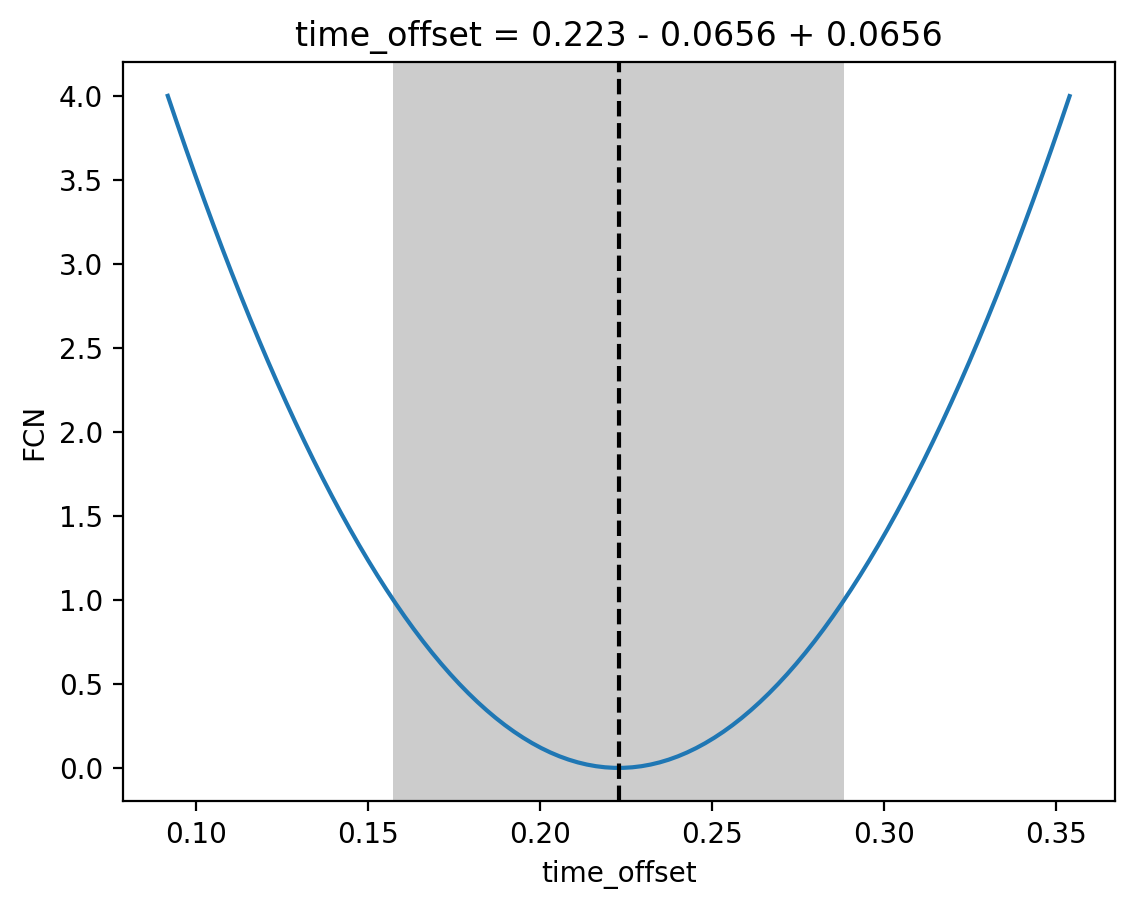

In [15]:
m.draw_profile("time_offset"); 
print(f'{m.values[0]/m.errors[0]:2.2} sigma from zero')

In [16]:
m.interactive(viz)

In [17]:
clean_df[['obsid', 'satellite', 'tle_delay', 'RA', 'DEC', 'RA_Start', 'RA_End', 'Error_Start', 'Error_End']]
#clean_df

,obsid,satellite,tle_delay,RA,DEC,RA_Start,RA_End,Error_Start,Error_End
0,GC102_O_20240422_000023,GOES 16,-10.885556,154.584239,5.065669,154.582710,154.603475,3.359,3.596
1,GC102_O_20240422_000023,STAR ONE C3,11.453889,154.828023,5.089200,154.828027,154.849251,3.314,2.692
2,GC102_O_20240422_000024,GOES 16,-10.888056,154.623573,5.065703,154.624067,154.641134,4.355,4.407
3,GC102_O_20240422_000024,STAR ONE C3,11.451389,154.867355,5.089246,154.867670,154.889026,4.390,4.650
4,GC102_O_20240422_000025,GOES 16,-10.890833,154.662531,5.065736,154.661607,154.682351,3.555,2.687
5,GC102_O_20240422_000025,STAR ONE C3,11.448611,154.906310,5.089292,154.907254,154.926302,3.086,3.392
6,GC102_O_20240422_000026,GOES 16,-10.893333,154.701104,5.065769,154.701910,154.721687,4.067,3.656
8,GC102_O_20240422_000027,GOES 16,-10.895833,154.739845,5.065802,154.740169,154.759838,3.921,3.734
10,GC102_O_20240423_000026,GOES 16,-4.904722,143.971462,5.045816,143.974880,143.993170,3.841,3.524
11,GC102_O_20240423_000026,STAR ONE C3,-11.775000,144.204543,5.073415,144.205772,144.223660,3.554,4.544
